> Contribution chính là đề xuất thuật toán để loại bỏ dịch chuyển, biến dạng ảnh không mong muốn của camera theo thời gian, đảm bảo các vị trí trong ảnh không bị thay đổi do các yếu tố bên ngoài (gió, nhiệt độ, ...)

# Data

* **Cao 43m**, cách đê chắn sóng 300m, cách bờ biển 100m về phía đất liền
* Tập trung camera **C1** bao phủ **75% bờ biển** dài **1.7km**
* Camera được quản lý bởi app **SIRENA** ghi hình ảnh theo 3 chế độ:
    * **Snapshot**: ảnh chụp tức thời
    * **Time exposure**: ảnh trung bình theo thời gian
    * **Standard deviation**: ảnh phương sai chuẩn
* Cứ mỗi **30 phút**, camera ghi lại ảnh trong **10 phút** với tốc độ **7.5Hz**

* Mực nước biển thay đổi theo mùa
* Có điều kiện nhật triều, biên độ mùa xuân là 75m
* Bãi biển **bồi tụ 6m/năm**


* Máy đo thủy triều **ADCP** đặt ở độ sâu 10m, cách bờ biển 10km

* Bãi biển kéo dài **2km** (với **20 cross-shore** transects with spacing of **100m**) 

# Method

## Environmental conditions

* Mức nước được tổng hợp lại bằng công thức:
$$ z_{total} = z_{gauge} + z_w + \frac{S}{2} \tag{1}$$

trong đó:
* $z_{gauge}$ là mực nước đo được từ máy đo **thủy triều**
* $z_w$ là mức nước dâng do **sóng** (wave setup):
$$ z_w = 0.016(H_0L_0)^{\frac{1}{2}} $$
* $S$ là **độ cao dao động** của nước do **sóng**:  
$$ S = 0.046(H_0L_0)^{\frac{1}{2}} $$

* Ngoài ra các yếu tố khí hậu: **gió mùa, không khí lạnh, bão** ảnh hưởng đáng kể đến sự thay đổi của đường bờ

## Quá trình xử lý hình ảnh

**Image Stabilization Algorithm**

* ✍️ defining the **unstabilized image** to be corrected and **its closest stabilized image** in time from the **database** of monthly  reference images

* ✂️ Mỗi ảnh được tách thành **2 ROI** và được xử lý riêng biệt bởi **SURF**:
    * **ROI 1** ở gần, dễ phát hiện đặc trưng hơn
    * **ROI 2** ở xa, giảm ngưỡng threshold để cân bằng số đặc trưng

* 🔢 **SURF**:
    * `Detect features`: thường là góc, cạnh, điểm có độ tương phản cao, dựa vào bộ lọc **Haar wavelet** để tìm vùng có thay đổi mạnh về cường độ sáng
    * `Extract features`: tạo **feature descriptor** cho mỗi điểm đặc trưng
    * `Find mathching features`: tính khoảng cách **Euclide** giữa **descriptor** giữa ảnh cần ổn định và ảnh tham chiếu, nếu 2 điểm có khoảng cách đủ nhỏ, được coi là 1 cặp **matching feature** 

* 🔗 Concatanate **ROI 1** và **ROI 2**

* 🔍 Ước lượng phép biến đổi hình học (**geomtric transformation**) dựa trên **matching feature** đã tìm được ở trên

* 📝 Kiểm tra xem có **đủ features** trong phép biến đổi hình học cho mỗi **ROI** không? nếu không thì làm lại từ đầu

* Tích lũy **~ 20 lần** các phép biến đổi này để tránh nhiễu
* Nếu **số lượng** phép biến đổi ít hơn **5** thì **lower threshold** và **reset iterations**

* 📊 Sau cùng, **apply mean transformation**

⚠️ *Note: việc chạy lại vẫn giữ nguyên `ảnh tham chiếu`, chỉ chạy lại thuật toán `SURF` do tính ngẫu nhiên khi detect features*

## Bộ ảnh

1️⃣ Non-Stabilized Oblique Images (**NSI**)
* Ảnh xiên gốc, chưa qua xử lý
* Vị trí cam bị thay đổi theo thời gian do **gió, nhiệt độ, bảo trì**

2️⃣ Stabilized Oblique Images (**SI**)
* Ảnh xiên sau khi xử lý
* Chỉ dùng **một hiệu chuẩn**

3️⃣ Planview Images from Stabilized Oblique Images (**Planview-SI**)
* Ảnh mặt bằng (**Hệ tọa độ thực tế UTM**) từ ảnh ổn định (**SI**)
* Có khoảng cách chính xác trong không gian thực
* Chỉ cần **một lần hiệu chuẩn**

4️⃣ Planview Images from Non-Stabilized Oblique Images (**Planview-NSI**)
* Ảnh mặt bằng (**UTM**) tạo ra từ ảnh **NSI** nhưng cần nhiều lần hiệu chỉnh
* Mỗi ảnh yêu cầu **hiệu chuẩn riêng** để giảm sai số

> Từ **100 ảnh NSI** tạo ra **100 ảnh cho mỗi loại**

## Shoreline Detection and Correction

### Shoreline Detection

* Shoreline được **manually detected** trong ảnh planviews
* Shoreline được định nghĩa là **ranh giới xa nhất của vùng sóng tràn lên (run-up limit)**
* Trong ảnh, là **pixel cuối cùng của vùng trắng bị mờ do sóng**

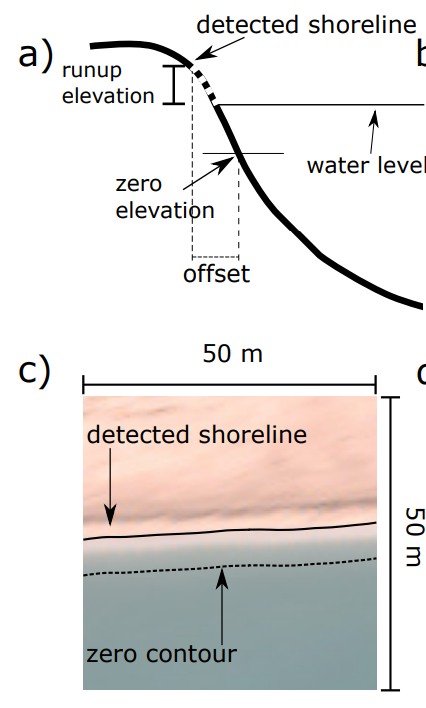

⚠️ Tuy nhiên trong thực địa, **đường bờ** được định nghĩa là vị trí **có độ cao 0m so với mực nước biển**

> Đường bờ phát hiện từ ảnh bị ảnh hưởng bở **mực nước biển và sóng** nên cần hiện chỉnh

### Shoreline correction

Tính **độ lệch ngang (cross-shore offset)** giữa đường bờ phát hiện và đường bờ chuẩn dựa trên:
* **Độ dốc trung bình bãi biển (foreshore slope)** từ các lần khảo sát thực địa
* **Mực nước biển tổng hợp (total water level)** tại thời điểm chụp ảnh (Công thức **(1)** ở mục **2.1**)

> Ứng dụng đề lệch này để chuyển đường bờ về vị trí chuẩn

# Results

## Raw assessment

*Đánh giá ban đầu khi chưa áp dụng* **shoreline correction**

✅ **Stabilization Algorithm** tìm được **geometric transfomation** hợp lệ:
* **80 ảnh** sử dụng ngưỡng chất lượng tối đa
* **20 ảnh** cần giảm ngưỡng

✅ Sử dụng vị trí của **the pier corner** để đánh giá thuật toán

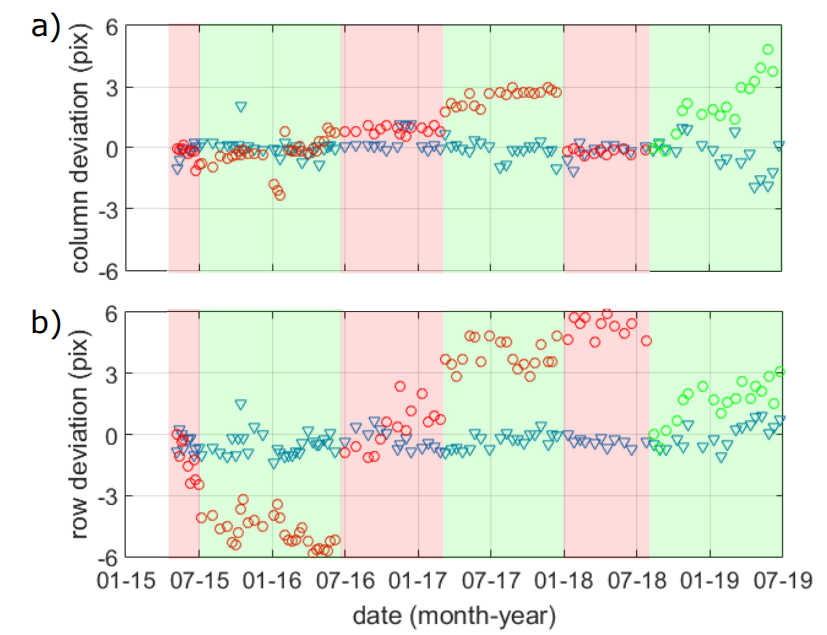

* ⚫: non-stabilized images (Dao động trong khoảng 6 pixel)
* 🔽: stabilized images (Dao động trong 0.7 pixel)

## Shoreline assessment

**Độ chính xác tổng thể của ảnh SI và NSI**:

* RMSE trung bình: 
    * SI shoreline: 1m
    * NSI shoreline: 1.4m
* Phân loại:
    * <1m: SI có **60 ảnh**, NSI có **39 ảnh**
    * 1-2m: SI > NSI
    * 2-3m, >3m: SI có **5 ảnh**, NSI có **11 ảnh**

**Biến động vị trí đường bờ theo thời gian**

* **Mean Absolute Bias**:
    * **P15 (gần camera)**:
        * SI: **0.75m**
        * NSI: **0.96m**
    * **P4 (xa camera)**:
        * SI: **0.96m**
        * NSI: **1.8m**

* **RMSE**:
    * **P15 (gần camera)**:
        * SI: **1.2m**
        * NSI: **1.5m**
    * **P4 (xa camera)**:
        * SI: **1.75m**
        * NSI: **3.5m**

**Sai số xu hướng dài hạn**:
* SI: **0.01 m/năm**
* NSI: **0.25 m/năm**